# Raw Attenuation vs BCc Correlation Analysis

## Research Question
Are the high correlations between wavelengths inherent to the aerosol, or artificially induced by processing algorithms?

## Data Flow in AE33 Aethalometer
```
Raw Attenuation (ATN)  →  Processing Algorithms  →  BCc (BC compensated)
        ↑                        ↑                         ↑
   What we analyze          Includes:                 What notebooks
   here                     • Loading compensation     typically use
                            • Scattering correction
                            • Smoothing
                            • Multiple scattering (C factor)
```

## Interpretation Guide
| If raw ATN correlations are... | Interpretation |
|-------------------------------|----------------|
| Similar to BCc correlations   | Correlations are real/inherent to aerosol |
| Lower than BCc correlations   | Processing may be artificially linking wavelengths |
| Higher than BCc correlations  | Processing may be adding noise/divergence |

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, './scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 2. Define Column Names

AE33 Aethalometer provides:
- **ATN1, ATN2**: Raw attenuation on spot 1 and spot 2 (for dual-spot compensation)
- **BCc**: Black carbon concentration (compensated/processed)

In [2]:
# Wavelengths available in AE33
WAVELENGTHS = ['UV', 'Blue', 'Green', 'Red', 'IR']

# Column names for raw attenuation (may vary by format)
# Standard format
ATN1_COLS_STD = [f'{wl} ATN1' for wl in WAVELENGTHS]
ATN2_COLS_STD = [f'{wl} ATN2' for wl in WAVELENGTHS]

# JPL format (with dots)
ATN1_COLS_JPL = [f'{wl}.ATN1' for wl in WAVELENGTHS]
ATN2_COLS_JPL = [f'{wl}.ATN2' for wl in WAVELENGTHS]

# BCc columns
BCC_COLS_STD = [f'{wl} BCc' for wl in WAVELENGTHS]
BCC_COLS_JPL = [f'{wl}.BCc' for wl in WAVELENGTHS]

# Also check for smoothed BCc
BCC_SMOOTH_COLS = [f'{wl} BCc smoothed' for wl in WAVELENGTHS]

print("ATN1 columns (standard):", ATN1_COLS_STD)
print("BCc columns (standard):", BCC_COLS_STD)

ATN1 columns (standard): ['UV ATN1', 'Blue ATN1', 'Green ATN1', 'Red ATN1', 'IR ATN1']
BCc columns (standard): ['UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']


## 3. Load Data and Check Available Columns

In [3]:
# Site configuration
SITES = {
    'Beijing': {
        'file': 'processed_sites/df_Beijing_9am_resampled.pkl',
        'color': '#E41A1C'
    },
    'Delhi': {
        'file': 'processed_sites/df_Delhi_9am_resampled.pkl',
        'color': '#377EB8'
    },
    'JPL': {
        'file': 'processed_sites/df_JPL_9am_resampled.pkl',
        'color': '#4DAF4A'
    },
    'Addis Ababa': {
        'file': 'processed_sites/df_Addis_Ababa_9am_resampled.pkl',
        'color': '#984EA3'
    }
}

# Load all site data
site_data = {}

for site_name, config in SITES.items():
    file_path = Path(config['file'])
    if file_path.exists():
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
        site_data[site_name] = df
        print(f"\n{site_name}: Loaded {len(df)} records")
    else:
        print(f"\n{site_name}: File not found - {file_path}")


Beijing: Loaded 590 records

Delhi: Loaded 289 records

JPL: Loaded 765 records

Addis Ababa: Loaded 515 records


In [4]:
# Check what columns are available for each site
def check_columns(df, site_name):
    """Check for ATN and BCc columns in the dataset."""
    print(f"\n{'='*60}")
    print(f"{site_name}: Column Analysis")
    print(f"{'='*60}")
    
    # Check ATN columns
    atn_cols = [c for c in df.columns if 'ATN' in c.upper()]
    print(f"\nATN columns found ({len(atn_cols)}):")
    for col in sorted(atn_cols):
        n_valid = df[col].notna().sum()
        print(f"  {col}: {n_valid} valid values")
    
    # Check BCc columns
    bcc_cols = [c for c in df.columns if 'BCc' in c or 'BC1' in c]
    print(f"\nBCc columns found ({len(bcc_cols)}):")
    for col in sorted(bcc_cols):
        n_valid = df[col].notna().sum()
        print(f"  {col}: {n_valid} valid values")
    
    return atn_cols, bcc_cols

# Check all sites
site_columns = {}
for site_name, df in site_data.items():
    atn_cols, bcc_cols = check_columns(df, site_name)
    site_columns[site_name] = {'atn': atn_cols, 'bcc': bcc_cols}


Beijing: Column Analysis

ATN columns found (46):
  Blue ATN1: 222 valid values
  Blue ATN1 rolling mean: 222 valid values
  Blue ATN1_roughness: 222 valid values
  Blue ATN2: 222 valid values
  Blue ATN2 rolling mean: 222 valid values
  Blue ATN2_roughness: 222 valid values
  Blue_ratio_dATN_flow: 145 valid values
  Green ATN1: 222 valid values
  Green ATN1 rolling mean: 222 valid values
  Green ATN2: 222 valid values
  Green ATN2 rolling mean: 222 valid values
  IR ATN1: 222 valid values
  IR ATN1 rolling mean: 222 valid values
  IR ATN1_roughness: 222 valid values
  IR ATN2: 222 valid values
  IR ATN2 rolling mean: 222 valid values
  IR ATN2_roughness: 222 valid values
  IR_ratio_dATN_flow: 121 valid values
  Red ATN1: 222 valid values
  Red ATN1 rolling mean: 222 valid values
  Red ATN2: 222 valid values
  Red ATN2 rolling mean: 222 valid values
  UV ATN1: 222 valid values
  UV ATN1 rolling mean: 222 valid values
  UV ATN2: 222 valid values
  UV ATN2 rolling mean: 222 valid values

## 4. Create Correlation Matrices

### 4.1 Helper Functions

In [5]:
def get_available_columns(df, col_list):
    """Return columns that exist in DataFrame."""
    return [c for c in col_list if c in df.columns]

def get_first_valid_corr(results, keys):
    """
    Get the first non-None correlation matrix from results dict.
    Handles DataFrame truth value issue by explicitly checking for None.
    
    Parameters:
    -----------
    results : dict with correlation matrices
    keys : list of keys to try in order
    
    Returns:
    --------
    tuple: (correlation_matrix or None, key_used or None)
    """
    for key in keys:
        val = results.get(key)
        if val is not None:
            return val, key
    return None, None

def calculate_correlation_matrix(df, columns, min_valid=10):
    """
    Calculate correlation matrix for given columns.
    
    Parameters:
    -----------
    df : DataFrame
    columns : list of column names
    min_valid : minimum valid values required
    
    Returns:
    --------
    DataFrame correlation matrix, or None if insufficient data
    """
    available_cols = get_available_columns(df, columns)
    
    if len(available_cols) < 2:
        print(f"  Insufficient columns: {len(available_cols)} found")
        return None
    
    # Get subset and drop rows with all NaN
    subset = df[available_cols].dropna(how='all')
    
    if len(subset) < min_valid:
        print(f"  Insufficient data: {len(subset)} rows")
        return None
    
    # Calculate correlation matrix
    corr_matrix = subset.corr()
    
    # Simplify column names for display
    simplified_names = {}
    for col in corr_matrix.columns:
        # Extract wavelength name
        for wl in WAVELENGTHS:
            if wl in col:
                if 'ATN1' in col:
                    simplified_names[col] = f'{wl}_ATN1'
                elif 'ATN2' in col:
                    simplified_names[col] = f'{wl}_ATN2'
                elif 'smoothed' in col.lower():
                    simplified_names[col] = f'{wl}_smooth'
                else:
                    simplified_names[col] = wl
                break
        if col not in simplified_names:
            simplified_names[col] = col
    
    corr_matrix = corr_matrix.rename(columns=simplified_names, index=simplified_names)
    
    return corr_matrix

def plot_correlation_heatmap(corr_matrix, title, ax=None, cmap='RdYlBu_r', vmin=0.5, vmax=1.0):
    """
    Plot correlation matrix as heatmap.
    
    Parameters:
    -----------
    corr_matrix : DataFrame correlation matrix
    title : str
    ax : matplotlib axes (optional)
    cmap : colormap
    vmin, vmax : color scale limits
    """
    if corr_matrix is None:
        if ax:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', fontsize=12)
            ax.set_title(title)
            ax.set_xticks([])
            ax.set_yticks([])
        return
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
                cmap=cmap, vmin=vmin, vmax=vmax, ax=ax,
                square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlation (R)'})
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    
print("Helper functions defined.")

Helper functions defined.


### 4.2 Calculate and Compare Correlations for Each Site

In [6]:
# Store results for comparison
correlation_results = {}

for site_name, df in site_data.items():
    print(f"\n{'='*70}")
    print(f"{site_name}: Correlation Analysis")
    print(f"{'='*70}")
    
    site_results = {}
    
    # Try both column naming conventions
    atn1_cols = get_available_columns(df, ATN1_COLS_STD) or get_available_columns(df, ATN1_COLS_JPL)
    atn2_cols = get_available_columns(df, ATN2_COLS_STD) or get_available_columns(df, ATN2_COLS_JPL)
    bcc_cols = get_available_columns(df, BCC_COLS_STD) or get_available_columns(df, BCC_COLS_JPL)
    bcc_smooth_cols = get_available_columns(df, BCC_SMOOTH_COLS)
    
    print(f"\nAvailable columns:")
    print(f"  ATN1: {len(atn1_cols)} wavelengths")
    print(f"  ATN2: {len(atn2_cols)} wavelengths")
    print(f"  BCc: {len(bcc_cols)} wavelengths")
    print(f"  BCc smoothed: {len(bcc_smooth_cols)} wavelengths")
    
    # Calculate correlation matrices
    if atn1_cols:
        print(f"\nCalculating ATN1 correlations...")
        site_results['atn1_corr'] = calculate_correlation_matrix(df, atn1_cols)
    
    if atn2_cols:
        print(f"Calculating ATN2 correlations...")
        site_results['atn2_corr'] = calculate_correlation_matrix(df, atn2_cols)
    
    if bcc_cols:
        print(f"Calculating BCc correlations...")
        site_results['bcc_corr'] = calculate_correlation_matrix(df, bcc_cols)
    
    if bcc_smooth_cols:
        print(f"Calculating BCc smoothed correlations...")
        site_results['bcc_smooth_corr'] = calculate_correlation_matrix(df, bcc_smooth_cols)
    
    correlation_results[site_name] = site_results


Beijing: Correlation Analysis

Available columns:
  ATN1: 5 wavelengths
  ATN2: 5 wavelengths
  BCc: 5 wavelengths
  BCc smoothed: 2 wavelengths

Calculating ATN1 correlations...
Calculating ATN2 correlations...
Calculating BCc correlations...
Calculating BCc smoothed correlations...

Delhi: Correlation Analysis

Available columns:
  ATN1: 5 wavelengths
  ATN2: 5 wavelengths
  BCc: 5 wavelengths
  BCc smoothed: 2 wavelengths

Calculating ATN1 correlations...
Calculating ATN2 correlations...
Calculating BCc correlations...
Calculating BCc smoothed correlations...

JPL: Correlation Analysis

Available columns:
  ATN1: 5 wavelengths
  ATN2: 5 wavelengths
  BCc: 5 wavelengths
  BCc smoothed: 2 wavelengths

Calculating ATN1 correlations...
Calculating ATN2 correlations...
Calculating BCc correlations...
Calculating BCc smoothed correlations...

Addis Ababa: Correlation Analysis

Available columns:
  ATN1: 5 wavelengths
  ATN2: 5 wavelengths
  BCc: 5 wavelengths
  BCc smoothed: 5 wavelength

## 5. Visualize Correlation Matrices

### 5.1 Side-by-Side Comparison: Raw ATN vs BCc


Beijing: ATN vs BCc Correlation Comparison


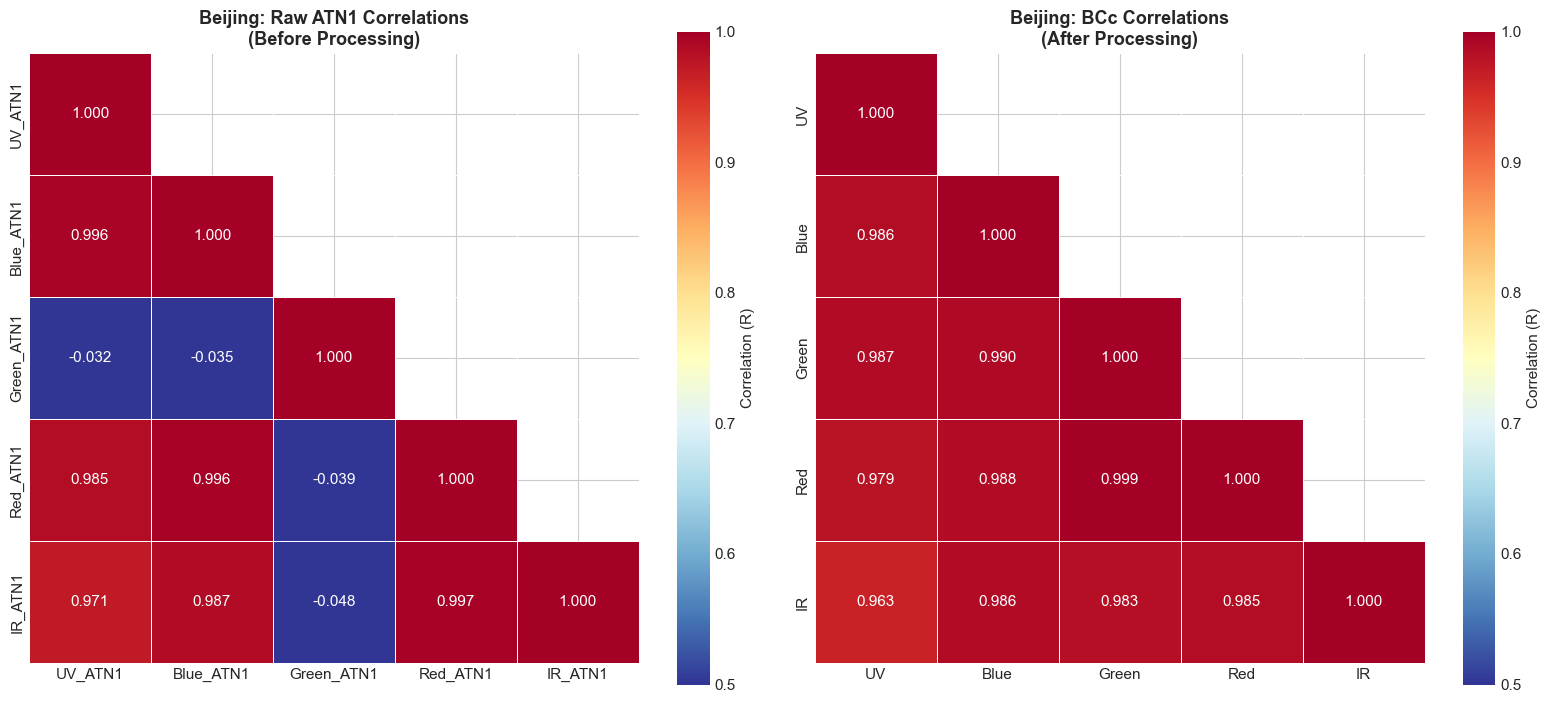


  Summary Statistics:
  Metric                           ATN        BCc   Difference
  ------------------------------------------------------------
  Mean correlation               0.578      0.985       +0.407
  Median correlation             0.978      0.986       +0.009
  Min correlation               -0.048      0.963       +1.011
  Max correlation                0.997      0.999       +0.002

Delhi: ATN vs BCc Correlation Comparison


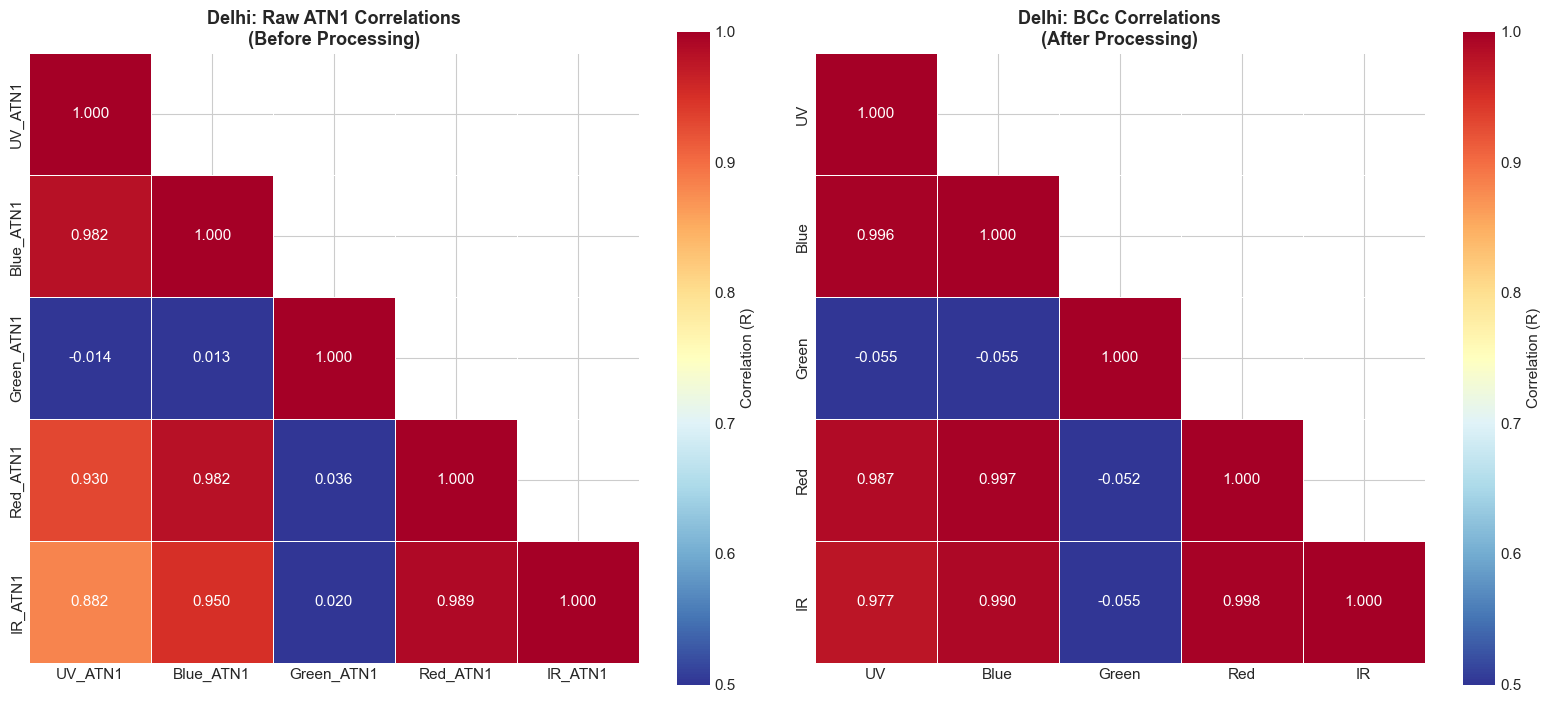


  Summary Statistics:
  Metric                           ATN        BCc   Difference
  ------------------------------------------------------------
  Mean correlation               0.577      0.573       -0.004
  Median correlation             0.906      0.982       +0.076
  Min correlation               -0.014     -0.055       -0.041
  Max correlation                0.989      0.998       +0.008

JPL: ATN vs BCc Correlation Comparison


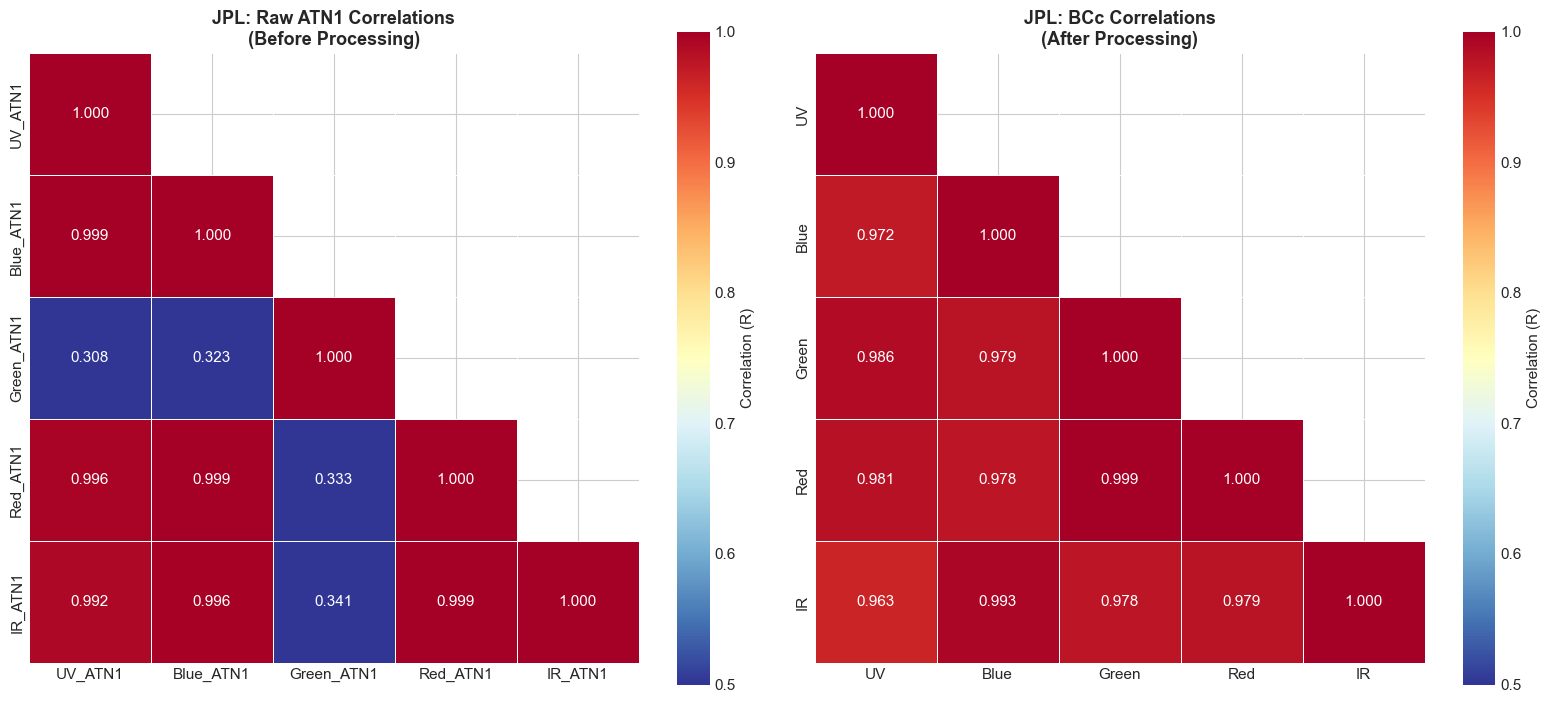


  Summary Statistics:
  Metric                           ATN        BCc   Difference
  ------------------------------------------------------------
  Mean correlation               0.729      0.981       +0.252
  Median correlation             0.994      0.979       -0.014
  Min correlation                0.308      0.963       +0.655
  Max correlation                0.999      0.999       +0.000

Addis Ababa: ATN vs BCc Correlation Comparison


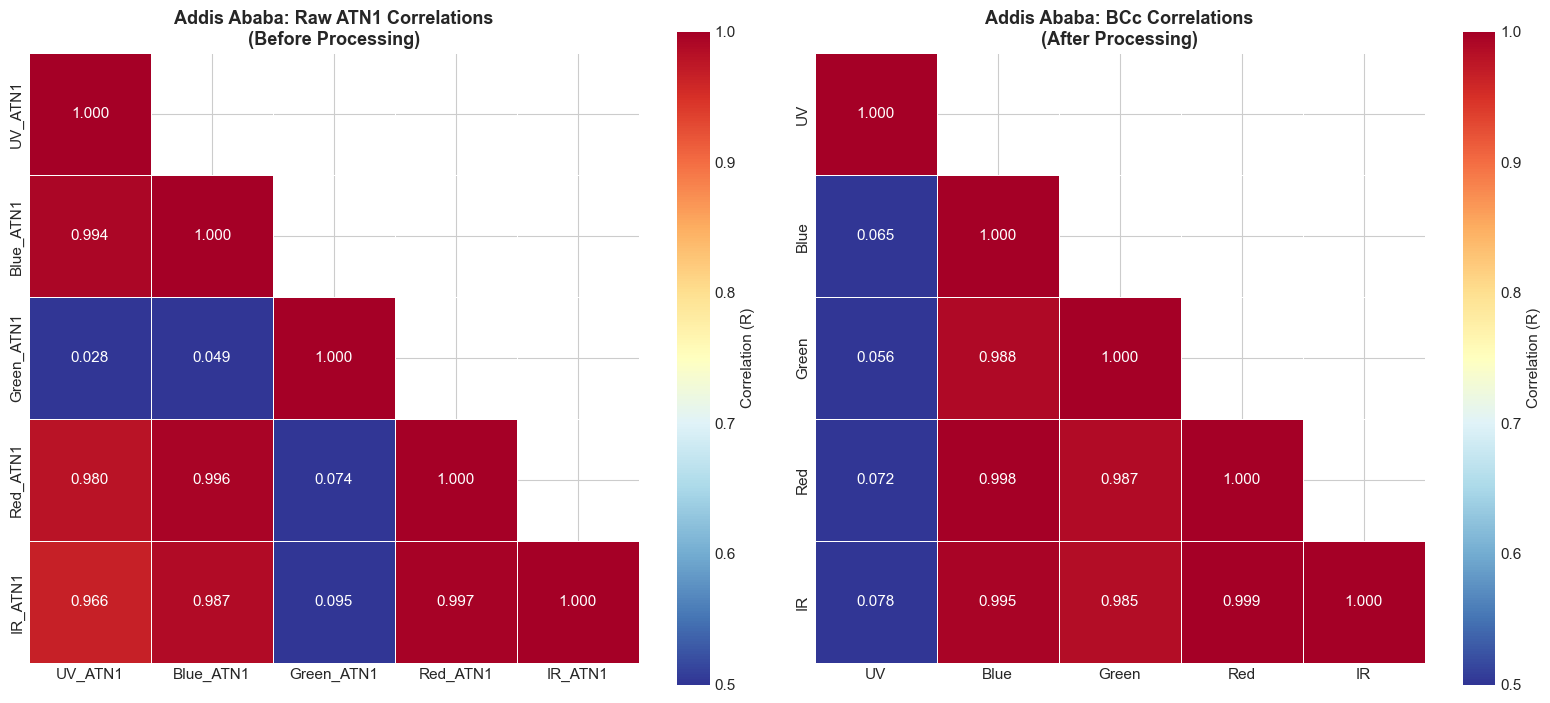


  Summary Statistics:
  Metric                           ATN        BCc   Difference
  ------------------------------------------------------------
  Mean correlation               0.617      0.622       +0.006
  Median correlation             0.973      0.986       +0.013
  Min correlation                0.028      0.056       +0.028
  Max correlation                0.997      0.999       +0.002


In [7]:
# Create comparison plots for each site
for site_name, results in correlation_results.items():
    print(f"\n{'='*70}")
    print(f"{site_name}: ATN vs BCc Correlation Comparison")
    print(f"{'='*70}")
    
    # Determine which ATN to use (prefer ATN1) - use helper to avoid DataFrame truth value issue
    atn_corr, atn_key = get_first_valid_corr(results, ['atn1_corr', 'atn2_corr'])
    atn_label = 'ATN1' if atn_key == 'atn1_corr' else 'ATN2'
    bcc_corr = results.get('bcc_corr')
    
    if atn_corr is None and bcc_corr is None:
        print("  No correlation data available for this site.")
        continue
    
    # Create side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Raw ATN correlation
    plot_correlation_heatmap(
        atn_corr, 
        f'{site_name}: Raw {atn_label} Correlations\n(Before Processing)',
        ax=axes[0]
    )
    
    # Right: BCc correlation
    plot_correlation_heatmap(
        bcc_corr,
        f'{site_name}: BCc Correlations\n(After Processing)',
        ax=axes[1]
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if atn_corr is not None and bcc_corr is not None:
        # Get off-diagonal correlations
        atn_vals = atn_corr.values[np.tril_indices_from(atn_corr.values, k=-1)]
        bcc_vals = bcc_corr.values[np.tril_indices_from(bcc_corr.values, k=-1)]
        
        print(f"\n  Summary Statistics:")
        print(f"  {'Metric':<25s} {'ATN':>10s} {'BCc':>10s} {'Difference':>12s}")
        print(f"  {'-'*60}")
        print(f"  {'Mean correlation':<25s} {np.mean(atn_vals):>10.3f} {np.mean(bcc_vals):>10.3f} {np.mean(bcc_vals) - np.mean(atn_vals):>+12.3f}")
        print(f"  {'Median correlation':<25s} {np.median(atn_vals):>10.3f} {np.median(bcc_vals):>10.3f} {np.median(bcc_vals) - np.median(atn_vals):>+12.3f}")
        print(f"  {'Min correlation':<25s} {np.min(atn_vals):>10.3f} {np.min(bcc_vals):>10.3f} {np.min(bcc_vals) - np.min(atn_vals):>+12.3f}")
        print(f"  {'Max correlation':<25s} {np.max(atn_vals):>10.3f} {np.max(bcc_vals):>10.3f} {np.max(bcc_vals) - np.max(atn_vals):>+12.3f}")

### 5.2 All Sites Comparison Grid

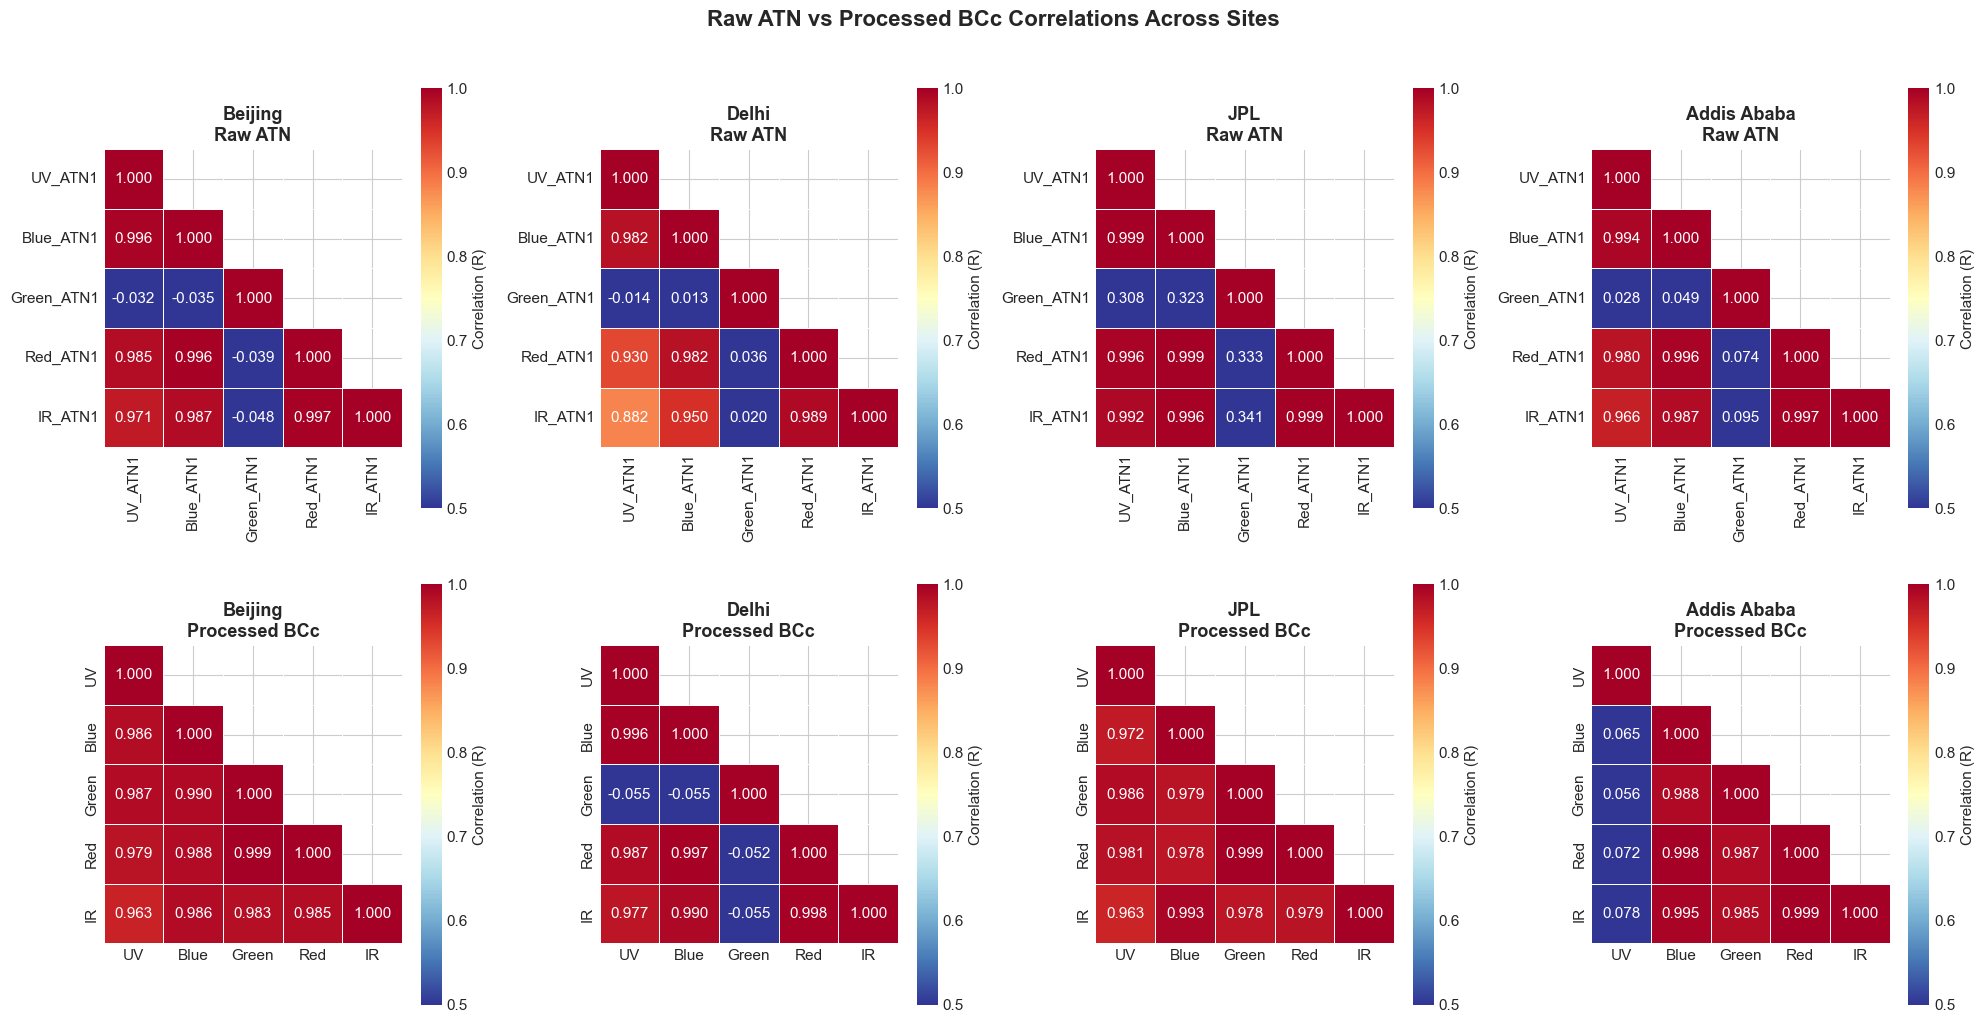

In [8]:
# Create a comprehensive comparison grid
n_sites = len([s for s in correlation_results if correlation_results[s].get('bcc_corr') is not None])

if n_sites > 0:
    fig, axes = plt.subplots(2, n_sites, figsize=(5*n_sites, 10))
    
    # Handle single site case
    if n_sites == 1:
        axes = axes.reshape(2, 1)
    
    col_idx = 0
    for site_name, results in correlation_results.items():
        # Use helper function to avoid DataFrame truth value issue
        atn_corr, _ = get_first_valid_corr(results, ['atn1_corr', 'atn2_corr'])
        bcc_corr = results.get('bcc_corr')
        
        if bcc_corr is None:
            continue
        
        # Top row: ATN
        plot_correlation_heatmap(
            atn_corr,
            f'{site_name}\nRaw ATN',
            ax=axes[0, col_idx]
        )
        
        # Bottom row: BCc
        plot_correlation_heatmap(
            bcc_corr,
            f'{site_name}\nProcessed BCc',
            ax=axes[1, col_idx]
        )
        
        col_idx += 1
    
    plt.suptitle('Raw ATN vs Processed BCc Correlations Across Sites', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No sites with sufficient data for comparison.")

## 6. Quantitative Comparison: Correlation Difference Analysis

In [9]:
# Calculate and visualize the difference between ATN and BCc correlations
print("="*80)
print("CORRELATION DIFFERENCE ANALYSIS: BCc - ATN")
print("="*80)
print("\nPositive difference = BCc correlations HIGHER than raw ATN")
print("Negative difference = BCc correlations LOWER than raw ATN")
print("\nInterpretation:")
print("  Positive: Processing may be artificially increasing correlations")
print("  Near zero: Correlations are inherent to the aerosol")
print("  Negative: Processing may be adding noise/reducing correlations")

diff_results = {}

for site_name, results in correlation_results.items():
    # Use helper function to avoid DataFrame truth value issue
    atn_corr, _ = get_first_valid_corr(results, ['atn1_corr', 'atn2_corr'])
    bcc_corr = results.get('bcc_corr')
    
    if atn_corr is None or bcc_corr is None:
        continue
    
    # Calculate difference matrix (where both have data)
    common_cols = list(set(atn_corr.columns) & set(bcc_corr.columns))
    
    if len(common_cols) < 2:
        continue
    
    atn_subset = atn_corr.loc[common_cols, common_cols]
    bcc_subset = bcc_corr.loc[common_cols, common_cols]
    
    diff_matrix = bcc_subset - atn_subset
    diff_results[site_name] = diff_matrix
    
    # Plot difference heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    mask = np.triu(np.ones_like(diff_matrix, dtype=bool), k=1)
    
    sns.heatmap(diff_matrix, mask=mask, annot=True, fmt='+.3f',
                cmap='RdBu_r', center=0, vmin=-0.2, vmax=0.2, ax=ax,
                square=True, linewidths=0.5,
                cbar_kws={'label': 'BCc - ATN Correlation'})
    
    ax.set_title(f'{site_name}: Correlation Difference (BCc - ATN)\nPositive = Processing Increases Correlation',
                 fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    diff_vals = diff_matrix.values[np.tril_indices_from(diff_matrix.values, k=-1)]
    print(f"\n{site_name}:")
    print(f"  Mean difference: {np.mean(diff_vals):+.4f}")
    print(f"  Max positive (processing increases): {np.max(diff_vals):+.4f}")
    print(f"  Max negative (processing decreases): {np.min(diff_vals):+.4f}")

CORRELATION DIFFERENCE ANALYSIS: BCc - ATN

Positive difference = BCc correlations HIGHER than raw ATN
Negative difference = BCc correlations LOWER than raw ATN

Interpretation:
  Positive: Processing may be artificially increasing correlations
  Near zero: Correlations are inherent to the aerosol
  Negative: Processing may be adding noise/reducing correlations


## 7. Summary Table

In [10]:
# Create summary table
print("\n" + "="*90)
print("SUMMARY: Mean Inter-Wavelength Correlations")
print("="*90)
print(f"\n{'Site':<15s} {'ATN Mean R':>12s} {'BCc Mean R':>12s} {'Difference':>12s} {'Interpretation':>30s}")
print("-"*85)

for site_name, results in correlation_results.items():
    # Use helper function to avoid DataFrame truth value issue
    atn_corr, _ = get_first_valid_corr(results, ['atn1_corr', 'atn2_corr'])
    bcc_corr = results.get('bcc_corr')
    
    if atn_corr is not None:
        atn_vals = atn_corr.values[np.tril_indices_from(atn_corr.values, k=-1)]
        atn_mean = np.mean(atn_vals)
    else:
        atn_mean = np.nan
    
    if bcc_corr is not None:
        bcc_vals = bcc_corr.values[np.tril_indices_from(bcc_corr.values, k=-1)]
        bcc_mean = np.mean(bcc_vals)
    else:
        bcc_mean = np.nan
    
    if not np.isnan(atn_mean) and not np.isnan(bcc_mean):
        diff = bcc_mean - atn_mean
        if abs(diff) < 0.02:
            interp = "Correlations inherent"
        elif diff > 0:
            interp = "Processing may link wavelengths"
        else:
            interp = "Processing adds divergence"
        
        print(f"{site_name:<15s} {atn_mean:>12.3f} {bcc_mean:>12.3f} {diff:>+12.3f} {interp:>30s}")
    else:
        print(f"{site_name:<15s} {'N/A':>12s} {'N/A':>12s} {'N/A':>12s} {'Insufficient data':>30s}")


SUMMARY: Mean Inter-Wavelength Correlations

Site              ATN Mean R   BCc Mean R   Difference                 Interpretation
-------------------------------------------------------------------------------------
Beijing                0.578        0.985       +0.407 Processing may link wavelengths
Delhi                  0.577        0.573       -0.004          Correlations inherent
JPL                    0.729        0.981       +0.252 Processing may link wavelengths
Addis Ababa            0.617        0.622       +0.006          Correlations inherent


## 8. Specific Wavelength Pair Analysis

Compare UV vs IR correlations specifically (most different wavelengths, indicative of source type)

In [11]:
# UV vs IR correlation comparison
print("\n" + "="*80)
print("UV vs IR CORRELATION COMPARISON")
print("="*80)
print("\nThis is particularly important for source apportionment:")
print("- High UV-IR correlation: Similar absorption at all wavelengths")
print("- Low UV-IR correlation: Different sources absorb differently at UV vs IR")
print()

print(f"{'Site':<15s} {'ATN UV-IR R':>15s} {'BCc UV-IR R':>15s} {'Change':>12s}")
print("-"*60)

for site_name, results in correlation_results.items():
    # Use helper function to avoid DataFrame truth value issue
    atn_corr, _ = get_first_valid_corr(results, ['atn1_corr', 'atn2_corr'])
    bcc_corr = results.get('bcc_corr')
    
    uv_ir_atn = None
    uv_ir_bcc = None
    
    # Get UV-IR correlation from ATN matrix
    if atn_corr is not None:
        for uv_col in atn_corr.columns:
            if 'UV' in uv_col:
                for ir_col in atn_corr.columns:
                    if 'IR' in ir_col:
                        uv_ir_atn = atn_corr.loc[uv_col, ir_col]
                        break
    
    # Get UV-IR correlation from BCc matrix
    if bcc_corr is not None:
        for uv_col in bcc_corr.columns:
            if 'UV' in uv_col:
                for ir_col in bcc_corr.columns:
                    if 'IR' in ir_col:
                        uv_ir_bcc = bcc_corr.loc[uv_col, ir_col]
                        break
    
    if uv_ir_atn is not None and uv_ir_bcc is not None:
        change = uv_ir_bcc - uv_ir_atn
        print(f"{site_name:<15s} {uv_ir_atn:>15.3f} {uv_ir_bcc:>15.3f} {change:>+12.3f}")
    else:
        print(f"{site_name:<15s} {'N/A':>15s} {'N/A':>15s} {'N/A':>12s}")


UV vs IR CORRELATION COMPARISON

This is particularly important for source apportionment:
- High UV-IR correlation: Similar absorption at all wavelengths
- Low UV-IR correlation: Different sources absorb differently at UV vs IR

Site                ATN UV-IR R     BCc UV-IR R       Change
------------------------------------------------------------
Beijing                   0.971           0.963       -0.008
Delhi                     0.882           0.977       +0.095
JPL                       0.992           0.963       -0.029
Addis Ababa               0.966           0.078       -0.888


## 9. Conclusions

### Key Findings

Based on the analysis above:

1. **If ATN and BCc correlations are similar**: The high inter-wavelength correlations are inherent to the aerosol properties, not artifacts of processing.

2. **If BCc correlations are higher than ATN**: The dual-spot compensation algorithm may be artificially linking wavelength channels together.

3. **If BCc correlations are lower than ATN**: Processing algorithms may be introducing wavelength-dependent noise.

### Implications for Source Apportionment

If UV-IR correlations are artificially enhanced by processing, this could affect:
- AAE (Absorption Angstrom Exponent) calculations
- Biomass burning vs fossil fuel source separation
- Delta-C calculations

In [12]:
print("\nAnalysis complete!")
print("\nNext steps:")
print("1. If ATN data not available: Check original raw data files for ATN columns")
print("2. Compare with other sites to see if pattern is consistent")
print("3. Consider time-dependent analysis (do correlations change over time?)")
print("4. Investigate specific outlier periods where correlations differ most")


Analysis complete!

Next steps:
1. If ATN data not available: Check original raw data files for ATN columns
2. Compare with other sites to see if pattern is consistent
3. Consider time-dependent analysis (do correlations change over time?)
4. Investigate specific outlier periods where correlations differ most
